# Bathymetry

Sample data: </br>
Single beam echo sounder data collected from the eastern forereef of One Tree Island on 23/03/2025 by Lachlan Perris

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.signal import medfilt


# Load raw data from the instrument

In [3]:

# Load the CSV file into a DataFrame
#df = pd.read_csv(f'250323_Bathy_survey_forereef.csv')
df = pd.read_csv(f'data/250323_forereef_survey_clip.csv')

df


,OID_,Field1,Pt_name,North,East,Depth_applied_elevation,Secondary_depth_applied_elevation,Code,Latency
0,23,22,SAG_BATH_00000,7399706.544,407875.822,-5.694,NaN,NaN,0
1,24,23,SAG_BATH_00001,7399707.040,407875.359,-5.400,NaN,NaN,0
2,25,24,SAG_BATH_00002,7399707.582,407875.021,-5.190,NaN,NaN,0
3,26,25,SAG_BATH_00003,7399708.122,407874.750,-5.152,NaN,NaN,0
4,27,26,SAG_BATH_00004,7399708.669,407874.763,-5.151,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
1072,1095,1094,SAG_BATH_01079,7400290.752,407925.842,-3.267,NaN,NaN,0
1073,1096,1095,SAG_BATH_01080,7400291.273,407926.012,-3.396,NaN,NaN,0
1074,1097,1096,SAG_BATH_01081,7400291.846,407926.171,-3.270,NaN,NaN,0
1075,1098,1097,SAG_BATH_01082,7400292.217,407926.625,-3.228,NaN,NaN,0


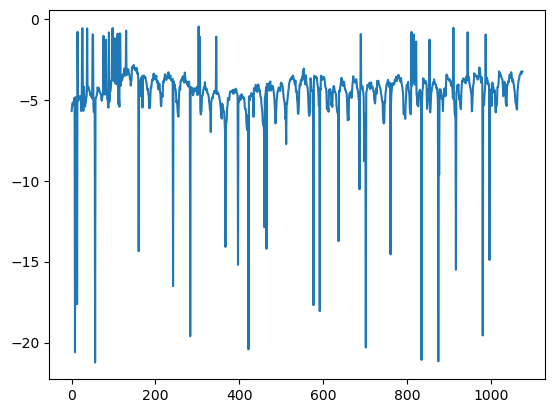

In [4]:
fig, ax = plt.subplots()
ax.plot(df['Depth_applied_elevation'])

### Still quite messy !

In [17]:
# ------------------------------------------------------------
# 1) Install & imports (run pip line once in your environment)
#    pip install geopandas folium
# ------------------------------------------------------------
import geopandas as gpd
import folium

# ------------------------------------------------------------
# 2) Inputs
#    - df: pandas DataFrame with columns 'East', 'North'
#    - SOURCE_EPSG: projected CRS of your East/North (change if needed)
# ------------------------------------------------------------
SOURCE_EPSG = 28356  # e.g., GDA94/MGA Zone 56; use your correct zone

# ------------------------------------------------------------
# 3) Build a GeoDataFrame and reproject to WGS84 (lat/lon) for web maps
# ------------------------------------------------------------
gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df['East'], df['North']),
    crs=f"EPSG:{SOURCE_EPSG}"
).to_crs(epsg=4326)

# ------------------------------------------------------------
# 4) Create a Folium map centred on your data with an IMAGE BASEMAP
#    - Using Esri World Imagery (satellite) tiles
# ------------------------------------------------------------
centre = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]
m = folium.Map(location=centre, zoom_start=13, tiles=None)  # start with no default tiles

folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Tiles © Esri — Source: Esri, Maxar, Earthstar Geographics, USDA, USGS, AeroGRID, IGN, and the GIS User Community",
    name="Esri World Imagery",
    overlay=False,
    control=True
).add_to(m)

# (Optional) add a simple reference basemap to toggle if you like
#folium.TileLayer("OpenStreetMap", name="OpenStreetMap", control=True).add_to(m)

# ------------------------------------------------------------
# 5) Add your points (simple markers; no colour by depth)
# ------------------------------------------------------------
for pt in gdf.geometry:
    folium.CircleMarker(
        location=[pt.y, pt.x],
        radius=3,
        fill=True,
        fill_opacity=0.9,
        weight=0
    ).add_to(m)

# ------------------------------------------------------------
# 6) Useful controls & output
# ------------------------------------------------------------
#folium.LayerControl().add_to(m)  # toggle basemaps
# In Jupyter, just display `m`; or save to file:
# m.save("points_map.html")
m


# Bathymetry despiking & smoothing (0.5 m sampling)

**Goal:** Clean a 0.5 m–spaced bathymetry profile by removing impulsive spikes and lightly smoothing noise, while preserving genuine seabed features.

---

## Method
1. **Median filter (despike)**  
   - `window_size = 3` → spans **1.5 m**.  
   - Replaces each value with the **median** of its neighbourhood. Robust to outliers (bad pings, bubbles), preserves sharp breaks.

2. **Rolling mean (smooth)**  
   - `rolling_window = 3` → spans **1.5 m**.  
   - Reduces residual high-frequency jitter; `center=True` avoids lateral shift.

3. **Plot**  
   - Visualise `depth_smoothed` to confirm noise reduction and feature retention.

---

## Parameters used
- Sampling: **0.5 m** along-track  
- Median window: **9 samples (4.5 m)**  
- Mean window: **3 samples (1.5 m)**

> Depths are negative (more negative = deeper). Filters operate the same.

---

## Quick QC
- Plot **raw vs despiked vs smoothed** together.  
- Check **residual = raw − smoothed** to ensure mainly noise is removed.  
- If over-smoothed → reduce window sizes; if spikes remain → increase the **median** window first.


In [6]:
# Step 1: Apply median filter to remove spikes
window_size = 3  # Choose an odd number for the window size (e.g., 3, 5, 7)

# Step 2: Apply rolling average to smooth the data further
rolling_window = 3# Choose the rolling window size


df['depth_despiked'] = medfilt(df['Depth_applied_elevation'], kernel_size=window_size)
df['depth_smoothed'] = df['depth_despiked'].rolling(window=rolling_window, center=True).mean()

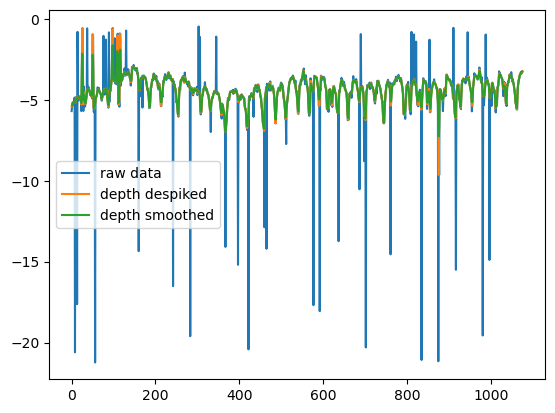

In [7]:
fig, ax = plt.subplots()
ax.plot(df['Depth_applied_elevation'], label = 'raw data')
ax.plot(df['depth_despiked'], label = 'depth despiked')
ax.plot(df['depth_smoothed'], label = 'depth smoothed')
ax.legend()
plt.show()

In [8]:
# Calculate Euclidean distances between consecutive points
dx = df['East'].diff()
dy = df['North'].diff()
df['segment_dist'] = np.sqrt(dx**2 + dy**2)

# First point has no previous point, so fill that with 0
df['segment_dist'] = df['segment_dist'].fillna(0)

# Cumulative distance from the start
df['Distance'] = df['segment_dist'].cumsum()

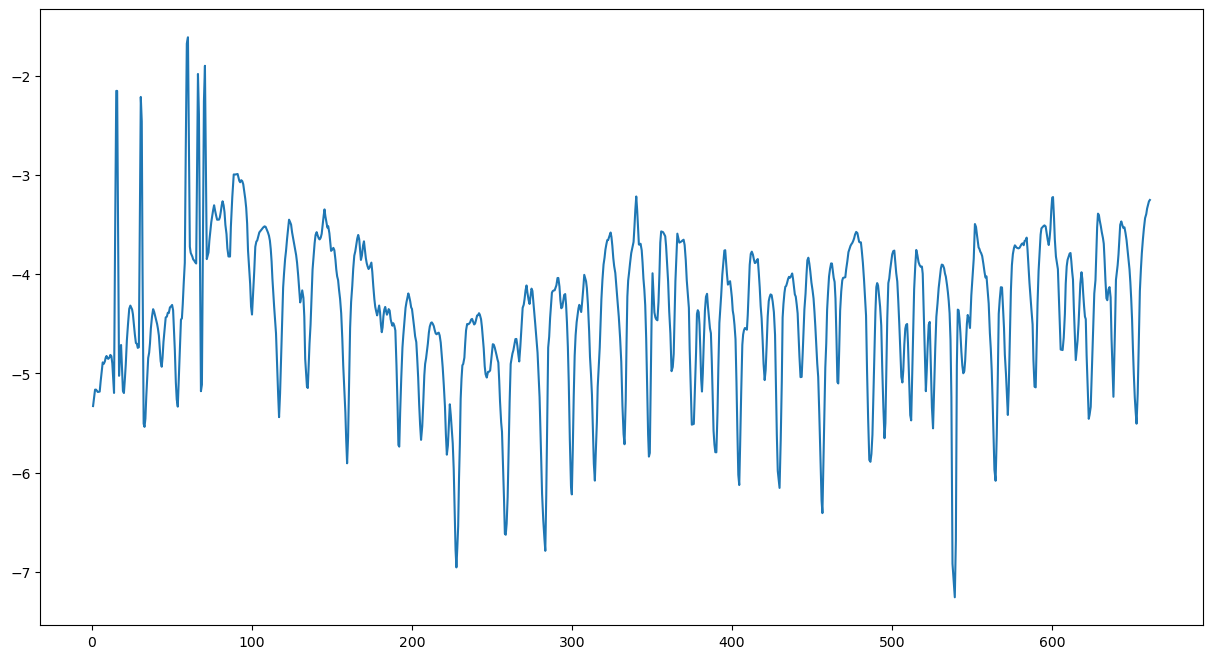

In [9]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(df['Distance'], df['depth_smoothed'])